# Levels Passed vs Simulation Runs

This notebook visualizes cumulative levels passed vs simulation runs from the metrics data.


In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Set style for better looking plots
# plt.style.use('seaborn-v0_8-darkgrid')
# plt.rcParams['figure.figsize'] = (16, 8)
# plt.rcParams['font.size'] = 12

import seaborn as sns
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({
    "figure.figsize": (16, 8),
    "font.family": "DejaVu Sans",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
})


/home/drew99/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Read the metrics data
log_dir = 'new_logs/logs_20251022-23/'
# log_dir = 'new_logs/logs_20251021_214908/'
# log_dir = 'new_logs/logs_20251015_121525/'
metrics_file = log_dir + 'metrics.jsonl'

data = []
with open(metrics_file, 'r') as f:
    for line in f:
        data.append(json.loads(line.strip()))

print(f"Total events: {len(data)}")


Total events: 1708


In [3]:
# Extract simulation runs and track cumulative levels passed
sim_runs = []
levels_passed = 0
global_sim_run = 0  # Global counter across all levels
current_category = None
category_changes = []

for event in data:
    if event['type'] == 'counter_inc' and event['name'] == 'simulation_runs':
        global_sim_run += 1  # Increment global counter
        category = event['level_context']['category']
        
        # Track category changes
        if current_category != category:
            category_changes.append({
                'sim_run': global_sim_run,
                'category': category
            })
            current_category = category
        
        sim_runs.append({
            'sim_run': global_sim_run,
            'category': category,
            'levels_passed': levels_passed
        })
    
    elif event['type'] == 'level_summary':
        if event['outcome'] == 'success':
            levels_passed += 1

df = pd.DataFrame(sim_runs)
print(f"Total simulation runs: {len(df)}")
print(f"Total levels passed: {levels_passed}")
print(f"\nCategory distribution:")
print(df['category'].value_counts())


Total simulation runs: 325
Total levels passed: 76

Category distribution:
category
open_door                     127
unlock_pickup                  76
unlock_door                    41
memory_ordering                24
hazard_avoidance               17
static_obstacle_navigation     15
goal_navigation                14
pickup_only                    11
Name: count, dtype: int64


In [4]:
# Display first few rows
df.head(10)


,sim_run,category,levels_passed
0,1,goal_navigation,0
1,2,goal_navigation,1
2,3,goal_navigation,1
3,4,goal_navigation,1
4,5,goal_navigation,2
5,6,goal_navigation,3
6,7,goal_navigation,4
7,8,goal_navigation,5
8,9,goal_navigation,6
9,10,goal_navigation,6


In [5]:
# Get total number of levels from curriculum
import json
with open('merged_curriculum2.json', 'r') as f:
    curriculum = json.load(f)
    
total_levels = sum(len(level['configs']) for cat in curriculum for level in cat['levels'])
print(f"Total levels in curriculum: {total_levels}")


Total levels in curriculum: 139


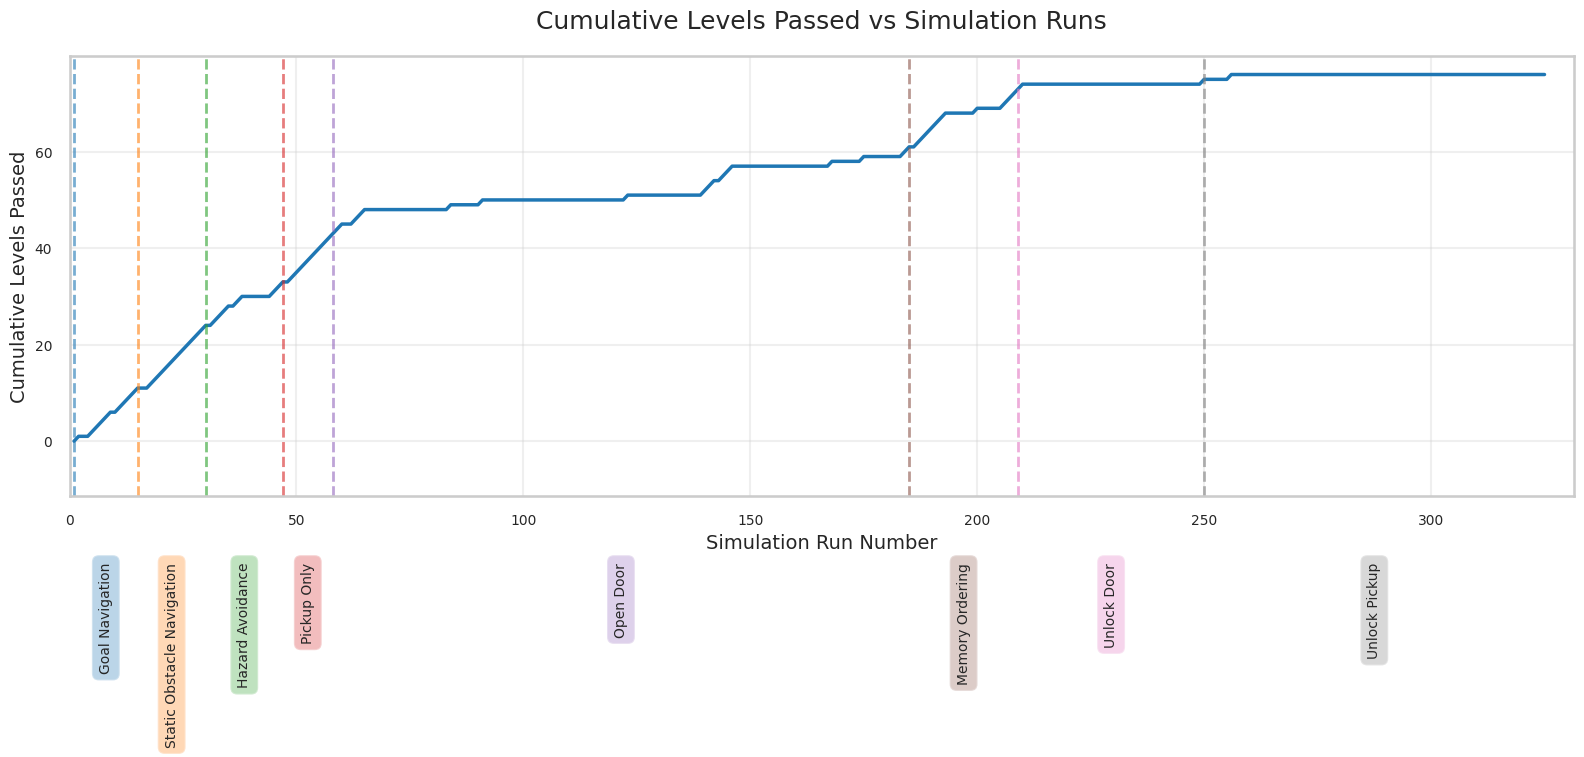


Plot saved to: new_logs/logs_20251022-23/levels_passed_plot.pdf


In [6]:
# Plot 1: Cumulative levels passed vs simulation runs
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the line
# ax.plot(df['sim_run'], df['levels_passed'], 'b-', linewidth=2)
ax.plot(df['sim_run'], df['levels_passed'],
        color=sns.color_palette("tab10")[0], linewidth=2.5)

# Add vertical lines at category changes (including the first one)
# colors_for_categories = plt.cm.Accent(np.linspace(0, 1, len(category_changes)))
colors_for_categories = sns.color_palette("tab10", n_colors=len(category_changes))
for i in range(len(category_changes)):
    ax.axvline(x=category_changes[i]['sim_run'], color=colors_for_categories[i], 
               linestyle='--', alpha=0.6, linewidth=2.0)

# Add category labels - one per category, centered in its range
for i, cat_change in enumerate(category_changes):
    # Category runs from where it starts to where the next category starts (or to end)
    start = cat_change['sim_run']
    
    if i < len(category_changes) - 1:
        # Not the last category: ends where next category starts
        end = category_changes[i+1]['sim_run']
    else:
        # Last category: ends at the end of data
        end = df['sim_run'].max()
    
    # Center the label between start and end
    x_pos = (start + end) / 2
    
    # # Add category label at bottom
    # ax.text(x_pos, -0.12, cat_change['category'].replace('_', ' ').title(), 
    #         ha='center', va='top', fontsize=10, fontweight='bold',
    #         bbox=dict(boxstyle='round,pad=0.5', facecolor=colors_for_categories[i], alpha=0.3),
    #         transform=ax.get_xaxis_transform())
    ax.text(x_pos, -0.15, cat_change['category'].replace('_', ' ').title(), 
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', facecolor=colors_for_categories[i], alpha=0.3),
            transform=ax.get_xaxis_transform(), rotation=90)

# Styling
# ax.set_xlabel('Simulation Run Number', fontsize=14, fontweight='bold')
# ax.set_ylabel('Cumulative Levels Passed', fontsize=14, fontweight='bold')
# ax.set_title('Cumulative Levels Passed vs Simulation Runs', fontsize=16, fontweight='bold', pad=20)
# ax.grid(True, alpha=0.3)
ax.set_xlabel('Simulation Run Number', fontsize=14)
ax.set_ylabel('Cumulative Levels Passed', fontsize=14)
ax.set_title('Cumulative Levels Passed vs Simulation Runs', fontsize=18, pad=20)
ax.grid(True, alpha=0.3)#, linestyle='--')
ax.set_xlim(0, df['sim_run'].max() * 1.02)
ax.set_ylim(bottom=-0.15 * df['levels_passed'].max())

ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(f'{log_dir}levels_passed_plot.pdf', dpi=300, bbox_inches='tight')
print(f"\nPlot saved to: {log_dir}levels_passed_plot.pdf")


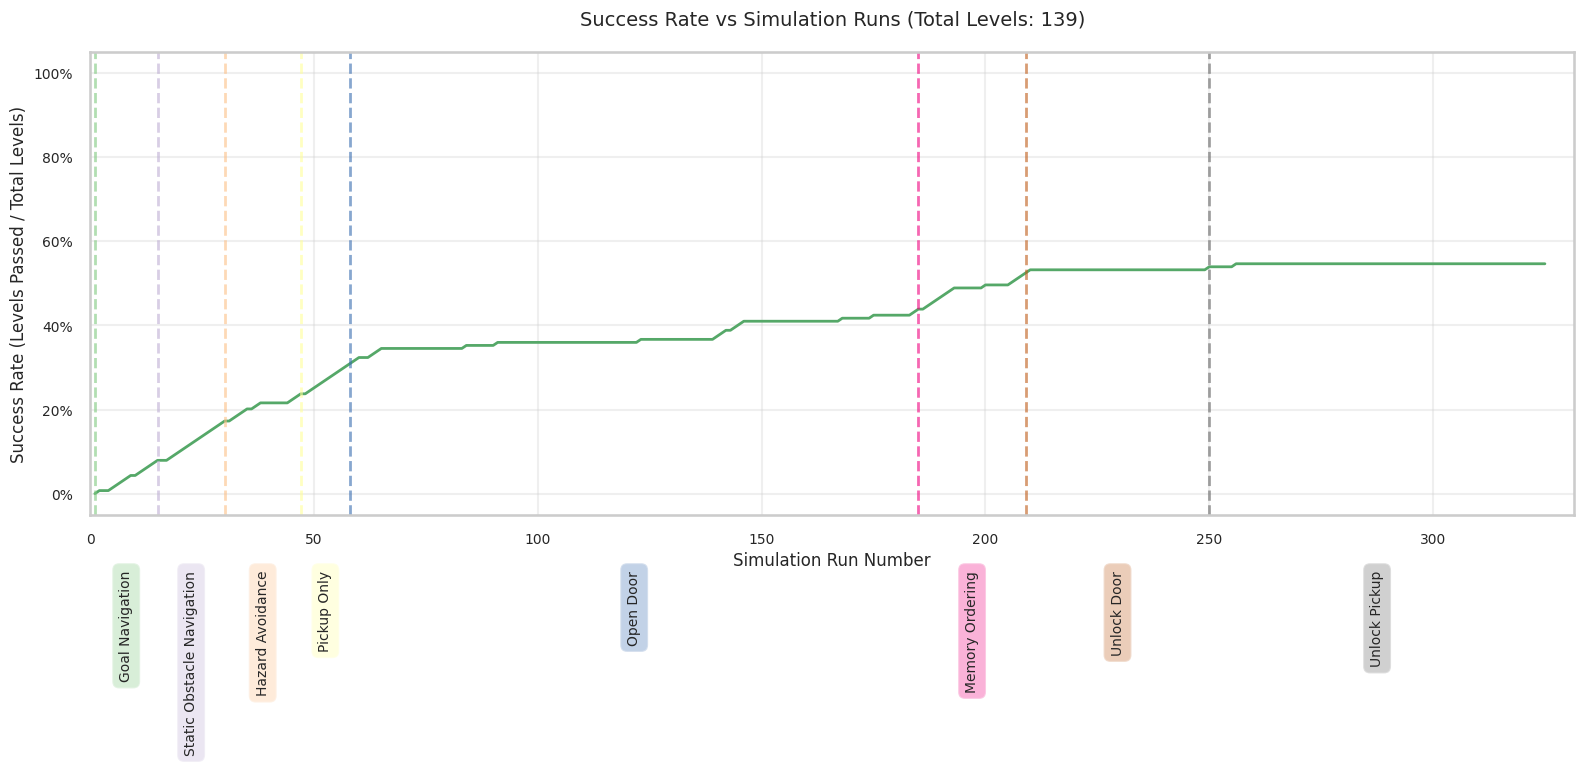


Plot saved to: new_logs/logs_20251022-23/success_rate_normalized_plot.png


In [7]:
# Plot 2: Normalized by total levels (success rate)
fig, ax = plt.subplots(figsize=(16, 8))

# Calculate normalized values
df['success_rate'] = df['levels_passed'] / total_levels

# Plot the line
ax.plot(df['sim_run'], df['success_rate'], 'g-', linewidth=2)

# Add vertical lines at category changes (including the first one)
colors_for_categories = plt.cm.Accent(np.linspace(0, 1, len(category_changes)))
for i in range(len(category_changes)):
    ax.axvline(x=category_changes[i]['sim_run'], color=colors_for_categories[i], 
               linestyle='--', alpha=0.6, linewidth=2.0)

# Add category labels - one per category, centered in its range
for i, cat_change in enumerate(category_changes):
    # Category runs from where it starts to where the next category starts (or to end)
    start = cat_change['sim_run']
    
    if i < len(category_changes) - 1:
        # Not the last category: ends where next category starts
        end = category_changes[i+1]['sim_run']
    else:
        # Last category: ends at the end of data
        end = df['sim_run'].max()
    
    # Center the label between start and end
    x_pos = (start + end) / 2
    
    # Add category label at bottom
    # y_pos = -0.12 if i%2 == 0 else -0.06
    # ax.text(x_pos, y_pos, cat_change['category'].replace('_', ' ').title(), 
    #         ha='center', va='top', fontsize=10, fontweight='bold',
    #         bbox=dict(boxstyle='round,pad=0.5', facecolor=colors_for_categories[i], alpha=0.3),
    #         transform=ax.get_xaxis_transform())
    # rotated by 45 degrees
    ax.text(x_pos, -0.12, cat_change['category'].replace('_', ' ').title(), 
            ha='center', va='top', fontsize=10, 
            bbox=dict(boxstyle='round,pad=0.5', facecolor=colors_for_categories[i], alpha=0.3),
            transform=ax.get_xaxis_transform(), rotation=90)

# Styling
ax.set_xlabel('Simulation Run Number', fontsize=12)
ax.set_ylabel('Success Rate (Levels Passed / Total Levels)', fontsize=12)
ax.set_title(f'Success Rate vs Simulation Runs (Total Levels: {total_levels})', fontsize=14, pad=20)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, df['sim_run'].max() * 1.02)
ax.set_ylim(-0.05, 1.05)

# Format y-axis as percentage
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(f'{log_dir}success_rate_normalized_plot.png', dpi=300, bbox_inches='tight')
print(f"\nPlot saved to: {log_dir}success_rate_normalized_plot.png")


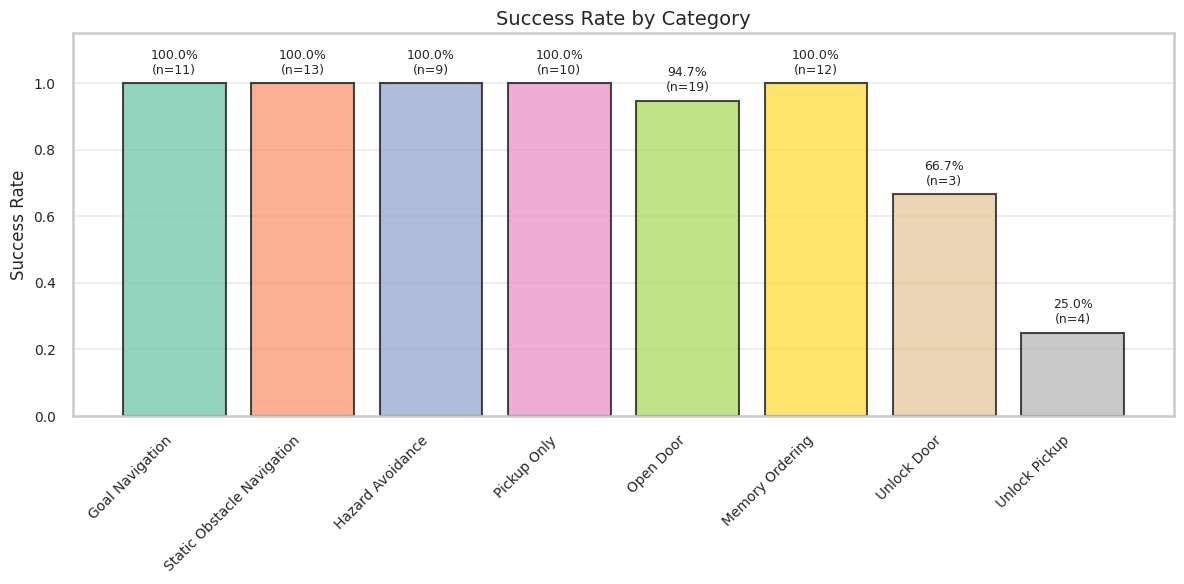

Plot saved to: new_logs/logs_20251022-23/success_by_category.png


In [8]:
# Calculate success rate by category from level_summary events
category_stats = []
for event in data:
    if event['type'] == 'level_summary':
        category_stats.append({
            'category': event['level_context']['category'],
            'success': 1 if event['outcome'] == 'success' else 0
        })

df_categories = pd.DataFrame(category_stats)
# Get the order of categories as they appear in the simulation
category_order = [cat['category'] for cat in category_changes]

# Group by category and reindex to preserve order
success_by_category = df_categories.groupby('category')['success'].agg(['sum', 'count', 'mean'])
success_by_category = success_by_category.reindex(category_order)

# Bar chart of success rate by category
fig, ax = plt.subplots(figsize=(12, 6))

colors_bars = plt.cm.Set2(np.linspace(0, 1, len(success_by_category)))

bars = ax.bar(range(len(success_by_category)), success_by_category['mean'].values, 
              color=colors_bars, alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(success_by_category)))
ax.set_xticklabels([cat.replace('_', ' ').title() for cat in success_by_category.index], 
                    rotation=45, ha='right')
ax.set_ylabel('Success Rate', fontsize=12)
ax.set_title('Success Rate by Category', fontsize=14)
ax.set_ylim(0, 1.15)
ax.grid(axis='y', alpha=0.3)
ax.grid(False, axis='x')

# Add value labels on bars
for i, (bar, val, count) in enumerate(zip(bars, success_by_category['mean'].values, success_by_category['count'].values)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{val:.1%}\n(n={int(count)})', ha='center', va='bottom', fontsize=9)

ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()

fig.savefig(f'{log_dir}success_by_category.png', dpi=300, bbox_inches='tight')
print(f"Plot saved to: {log_dir}success_by_category.png")


In [9]:
# Show category change points
print("\nCategory Change Points:")
for i, change in enumerate(category_changes, 1):
    print(f"{i}. At sim run {change['sim_run']}: {change['category'].replace('_', ' ').title()}")
    
print(f"\nFinal stats:")
print(f"Total simulation runs: {len(df)}")
print(f"Total levels passed: {levels_passed}")
print(f"Overall success rate: {levels_passed / total_levels:.2%}")



Category Change Points:
1. At sim run 1: Goal Navigation
2. At sim run 15: Static Obstacle Navigation
3. At sim run 30: Hazard Avoidance
4. At sim run 47: Pickup Only
5. At sim run 58: Open Door
6. At sim run 185: Memory Ordering
7. At sim run 209: Unlock Door
8. At sim run 250: Unlock Pickup

Final stats:
Total simulation runs: 325
Total levels passed: 76
Overall success rate: 54.68%


## Statistics Summary

Extract detailed statistics from level summaries.


In [10]:
# Extract level summaries for statistics
level_summaries = []
for event in data:
    if event['type'] == 'level_summary':
        level_summaries.append(event)

# Overall statistics
num_evaluated_levels = len(level_summaries)
num_evaluated_categories = len(set(ls['level_context']['category'] for ls in level_summaries))
num_successes = sum(1 for ls in level_summaries if ls['outcome'] == 'success')
completion_rate = num_successes / num_evaluated_levels if num_evaluated_levels > 0 else 0

# Total simulation runs
total_sim_runs = sum(ls['counters']['simulation_runs'] for ls in level_summaries)

# Total calls
total_planner_calls = sum(ls['counters']['planner_calls'] for ls in level_summaries)
total_coder_calls = sum(ls['counters']['coder_calls'] for ls in level_summaries)
total_spca_rounds = sum(ls['counters']['spca_rounds'] for ls in level_summaries)

# Time statistics (in minutes)
elapsed_times = [ls['elapsed_min'] for ls in level_summaries]
total_active_span_min = sum(elapsed_times)
avg_time_per_level = np.mean(elapsed_times)
std_time_per_level = np.std(elapsed_times)

# SPCA rounds per level
spca_rounds_per_level = [ls['counters']['spca_rounds'] for ls in level_summaries]
avg_spca_rounds = np.mean(spca_rounds_per_level)
std_spca_rounds = np.std(spca_rounds_per_level)

print("=" * 80)
print("OVERALL STATISTICS")
print("=" * 80)
print(f"Total levels (in curriculum):        {total_levels}")
# print(f"Total categories (in curriculum):    {len(set(cat['category'] for cat in category_changes))}")
print(f"Total categories (in curriculum):    9")
print(f"Evaluated levels:                    {num_evaluated_levels}")
print(f"Evaluated categories:                {num_evaluated_categories}")
print(f"Completion rate (success rate):      {completion_rate:.2%} ({num_successes}/{num_evaluated_levels})")
print(f"Total simulation runs:               {total_sim_runs}")
print(f"Total SPCA rounds:                   {total_spca_rounds}")
print(f"Total planner calls:                 {total_planner_calls}")
print(f"Total coder calls:                   {total_coder_calls}")
print(f"Active span:                         {total_active_span_min:.2f} minutes ({total_active_span_min/60:.2f} hours)")
print(f"Avg time per level:                  {avg_time_per_level:.2f} ± {std_time_per_level:.2f} minutes")
print(f"Avg SPCA rounds per level:           {avg_spca_rounds:.2f} ± {std_spca_rounds:.2f}")
print()


OVERALL STATISTICS
Total levels (in curriculum):        139
Total categories (in curriculum):    9
Evaluated levels:                    81
Evaluated categories:                8
Completion rate (success rate):      93.83% (76/81)
Total simulation runs:               325
Total SPCA rounds:                   112
Total planner calls:                 146
Total coder calls:                   225
Active span:                         252.49 minutes (4.21 hours)
Avg time per level:                  3.12 ± 6.45 minutes
Avg SPCA rounds per level:           1.38 ± 1.00



In [11]:
# Planner statistics
planner_scenarios = ['planner_fresh', 'planner_reuse', 'planner_replan', 'planner_syntax']
planner_stats = {}

for scenario in planner_scenarios:
    # Per-level counts
    per_level_counts = [ls['counters'][scenario] for ls in level_summaries]
    total_count = sum(per_level_counts)
    mean_per_level = np.mean(per_level_counts)
    std_per_level = np.std(per_level_counts)
    percentage = (total_count / total_planner_calls * 100) if total_planner_calls > 0 else 0
    
    planner_stats[scenario] = {
        'total': total_count,
        'mean': mean_per_level,
        'std': std_per_level,
        'percentage': percentage
    }

print("=" * 80)
print("PLANNER STATISTICS")
print("=" * 80)
print(f"{'Scenario':<20} {'Total Calls':<15} {'Per-Level Mean±SD':<25} {'Percentage':<15}")
print("-" * 80)
for scenario in planner_scenarios:
    stats = planner_stats[scenario]
    scenario_name = scenario.replace('planner_', '').title()
    print(f"{scenario_name:<20} {stats['total']:<15} {stats['mean']:.2f} ± {stats['std']:.2f} {'':<12} {stats['percentage']:.1f}%")
print(f"{'TOTAL':<20} {total_planner_calls:<15}")
print()


PLANNER STATISTICS
Scenario             Total Calls     Per-Level Mean±SD         Percentage     
--------------------------------------------------------------------------------
Fresh                8               0.10 ± 0.30              5.5%
Reuse                69              0.85 ± 0.36              47.3%
Replan               31              0.38 ± 1.00              21.2%
Syntax               34              0.42 ± 0.94              23.3%
TOTAL                146            



In [12]:
# Coder statistics
coder_scenarios = ['coder_first', 'coder_semantic', 'coder_syntax']
coder_stats = {}

for scenario in coder_scenarios:
    # Per-level counts
    per_level_counts = [ls['counters'][scenario] for ls in level_summaries]
    total_count = sum(per_level_counts)
    mean_per_level = np.mean(per_level_counts)
    std_per_level = np.std(per_level_counts)
    percentage = (total_count / total_coder_calls * 100) if total_coder_calls > 0 else 0
    
    coder_stats[scenario] = {
        'total': total_count,
        'mean': mean_per_level,
        'std': std_per_level,
        'percentage': percentage
    }

print("=" * 80)
print("CODER STATISTICS")
print("=" * 80)
print(f"{'Scenario':<20} {'Total Calls':<15} {'Per-Level Mean±SD':<25} {'Percentage':<15}")
print("-" * 80)
for scenario in coder_scenarios:
    stats = coder_stats[scenario]
    scenario_name = scenario.replace('coder_', '').title()
    print(f"{scenario_name:<20} {stats['total']:<15} {stats['mean']:.2f} ± {stats['std']:.2f} {'':<12} {stats['percentage']:.1f}%")
print(f"{'TOTAL':<20} {total_coder_calls:<15}")
print()


CODER STATISTICS
Scenario             Total Calls     Per-Level Mean±SD         Percentage     
--------------------------------------------------------------------------------
First                12              0.15 ± 0.36              5.3%
Semantic             213             2.63 ± 6.12              94.7%
Syntax               0               0.00 ± 0.00              0.0%
TOTAL                225            



In [13]:
# Create a summary dataframe for easy viewing
summary_data = {
    'Metric': [
        'Total Levels (Curriculum)',
        'Total Categories (Curriculum)',
        'Evaluated Levels',
        'Evaluated Categories',
        'Completion Rate',
        'Total Simulation Runs',
        'Total SPCA Rounds',
        'Total Planner Calls',
        'Total Coder Calls',
        'Active Span (hours)',
        'Avg Time per Level (min)',
        'Avg SPCA Rounds per Level'
    ],
    'Value': [
        total_levels,
        len(set(cat['category'] for cat in category_changes)),
        num_evaluated_levels,
        num_evaluated_categories,
        f"{completion_rate:.2%}",
        total_sim_runs,
        total_spca_rounds,
        total_planner_calls,
        total_coder_calls,
        f"{total_active_span_min/60:.2f}",
        f"{avg_time_per_level:.2f} ± {std_time_per_level:.2f}",
        f"{avg_spca_rounds:.2f} ± {std_spca_rounds:.2f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "=" * 80)
print("SUMMARY TABLE")
print("=" * 80)
print(summary_df.to_string(index=False))
print("=" * 80)



SUMMARY TABLE
                       Metric       Value
    Total Levels (Curriculum)         139
Total Categories (Curriculum)           8
             Evaluated Levels          81
         Evaluated Categories           8
              Completion Rate      93.83%
        Total Simulation Runs         325
            Total SPCA Rounds         112
          Total Planner Calls         146
            Total Coder Calls         225
          Active Span (hours)        4.21
     Avg Time per Level (min) 3.12 ± 6.45
    Avg SPCA Rounds per Level 1.38 ± 1.00


In [14]:
# Analyze levels by category to find which took the longest (most simulation runs)

category = 'open_door'

# Extract level summaries for the specified category
category_levels = []
for event in data:
    if event['type'] == 'level_summary' and event['level_context']['category'] == category:
        category_levels.append({
            'level_name': event['level']['level_name'],
            'lvl_group': event['level']['lvl_group'],
            'seed': event['level']['seed'],
            'outcome': event['outcome'],
            'simulation_runs': event['counters']['simulation_runs'],
            'elapsed_min': event['elapsed_min'],
            'spca_rounds': event['counters']['spca_rounds'],
            'planner_calls': event['counters']['planner_calls'],
            'coder_calls': event['counters']['coder_calls']
        })

if not category_levels:
    print(f"No levels found for category: {category}")
else:
    # Sort by simulation runs (descending)
    category_levels.sort(key=lambda x: x['simulation_runs'], reverse=True)

    print("=" * 100)
    print(f"{category.upper().replace('_', ' ')} LEVELS - SORTED BY SIMULATION RUNS (MOST TO LEAST)")
    print("=" * 100)
    print(f"{'Level Name':<35} {'Group':<15} {'Seed':<6} {'Outcome':<8} {'Sim Runs':<10} {'Time (min)':<12} {'SPCA':<6} {'Planner':<8} {'Coder':<6}")
    print("-" * 100)

    for level in category_levels[:5]:
        print(f"{level['level_name']:<35} {level['lvl_group']:<15} {level['seed']:<6} {level['outcome']:<8} {level['simulation_runs']:<10} {level['elapsed_min']:<12.2f} {level['spca_rounds']:<6} {level['planner_calls']:<8} {level['coder_calls']:<6}")

    print(f"\nTotal {category} levels analyzed: {len(category_levels)}")
    avg_sim_runs = sum(level['simulation_runs'] for level in category_levels) / len(category_levels)
    print(f"Average simulation runs per {category} level: {avg_sim_runs:.2f}")

    # # Show top 5 most challenging levels
    # print(f"\nTop 5 most challenging {category} levels:")
    # for i, level in enumerate(category_levels[:5], 1):
    #     print(f"{i}. {level['level_name']} (Group: {level['lvl_group']}, Seed: {level['seed']}) - {level['simulation_runs']} sim runs, {level['elapsed_min']:.2f} min")


OPEN DOOR LEVELS - SORTED BY SIMULATION RUNS (MOST TO LEAST)
Level Name                          Group           Seed   Outcome  Sim Runs   Time (min)   SPCA   Planner  Coder 
----------------------------------------------------------------------------------------------------
MiniGrid-GoToDoor-8x8-v0            Go To Door      1      fail     30         18.16        5      5        25    
BabyAI-Open-v0                      Open            1      success  22         11.97        4      4        18    
MiniGrid-GoToDoor-5x5-v0            Go To Door      1      success  19         13.42        4      6        15    
BabyAI-PickupAbove-v0               Pickup Above    1      success  17         13.70        3      3        15    
MiniGrid-MultiRoom-N4-S5-v0         Multi Room      1      success  9          3.43         2      2        7     

Total open_door levels analyzed: 19
Average simulation runs per open_door level: 6.68
